# * Postpaid Performance

## Import Data Source

In [105]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [106]:
as_week = 2023024
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
postpaid_rev_cd_list = ['B2R000100', 'B2R000101', 'B2R000102']
postpaid_dtac_rev_cd_list = ['DB2R000100', 'DB2R000101', 'DB2R000102']
postpaid_tmh_rev_cd_list = ['TB2R000100', 'TB2R000101', 'TB2R000102']
postpaid_all_rev_cd_list = postpaid_rev_cd_list + postpaid_dtac_rev_cd_list + postpaid_tmh_rev_cd_list
postpaid_total_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']

In [107]:
df.shape

(58785, 22)

In [108]:
# ''' Find Metric '''
# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Postpaid"]#.reset_index()
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('Postpaid_Metric.xlsx', index=False)
# df_tmp

## Data Preporation

In [109]:
''' Function '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

In [110]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(postpaid_all_rev_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
26690,20230619,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,347.63266,2393.380315,374.707331,2514.335102,2023-06-22 14:02:28,June,25,19
26691,20230620,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,NaN,2393.380315,NaN,2514.335102,2023-06-22 14:02:28,June,25,20
26692,20230621,2023025,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,NaN,2393.380315,NaN,2514.335102,2023-06-22 14:02:28,June,25,21


In [111]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [112]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [113]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

# # df_rev_day.to_excel('df_rev_mth.xlsx')
df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1014,26690,TB2R000100,Postpaid Revenue : TMH,20230619,2023025,202306,20232,2023,June,19,...,2393.380315,374.707331,2514.335102,347.63266,374.707331,0.927744,-27.074671,NaN,NaN,NaN
1015,26691,TB2R000100,Postpaid Revenue : TMH,20230620,2023025,202306,20232,2023,June,20,...,2393.380315,NaN,2514.335102,NaN,NaN,NaN,NaN,347.63266,NaN,NaN
1016,26692,TB2R000100,Postpaid Revenue : TMH,20230621,2023025,202306,20232,2023,June,21,...,2393.380315,NaN,2514.335102,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Existing Revenue': 'EXIST', 'Postpaid Existing Revenue : DTAC': 'EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'EXIST_TMH', 
             'Postpaid New Revenue': 'NEW', 'Postpaid New Revenue : DTAC': 'NEW_DTAC', 'Postpaid New Revenue : TMH': 'NEW_TMH', 
             'Postpaid Revenue': 'TOTAL', 'Postpaid Revenue : DTAC': 'TOTAL_DTAC', 'Postpaid Revenue : TMH': 'TOTAL_TMH'}

In [115]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC   
METRIC_NAME                                                                 
110           20230619   2023025     202306      20232      2023     June  \
111           20230620   2023025     202306      20232      2023     June   
112           20230621   2023025     202306      20232      2023     June   

            DAY_LABEL    ACT_SNAP                         ...      DIFF   
METRIC_NAME                 EXIST EXIST_DTAC   EXIST_TMH  ... TOTAL_TMH   
110                19  392.889777  82.342251  310.547526  ...       NaN  \
111                20         NaN  81.792725         NaN  ...       NaN   
112                21         NaN        NaN         NaN  ...       NaN   

                %DOD                                                    
METRIC_NAME    EXIST EXIST_DTAC EXIST_TMH       NEW  NEW_DTAC NEW_TMH   
110          3.95675   0.038841       NaN  5.548558 -0.024354     NaN  \
111              NaN  -0.006674       NaN       NaN  0.051087     NaN   
112              NaN        NaN       NaN       NaN       NaN     NaN   

                                            
METRIC_NAME     TOTAL TOTAL_DTAC TOTAL_TMH  
110          4.080038   0.033946       NaN  
111               NaN  -0.002452       NaN  
112               NaN        NaN       NaN  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [116]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

# df_rev_yr.to_excel('df_rev_yr.xlsx')
df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B2R000100,Postpaid Revenue,2023,S,24053.078840,24349.117793,0.987842,-296.038953,NaN,NaN,NaN
1,B2R000101,Postpaid New Revenue,2023,S,1532.137143,0.000000,inf,1532.137143,NaN,NaN,NaN
2,B2R000102,Postpaid Existing Revenue,2023,S,22520.941696,0.000000,inf,22520.941696,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,10805.902130,10996.650190,0.982654,-190.748060,NaN,NaN,NaN
4,DB2R000101,Postpaid New Revenue : DTAC,2023,S,661.302751,0.000000,inf,661.302751,NaN,NaN,NaN
5,DB2R000102,Postpaid Existing Revenue : DTAC,2023,S,10144.599380,0.000000,inf,10144.599380,NaN,NaN,NaN
6,TB2R000100,Postpaid Revenue : TMH,2023,S,13335.793591,13440.185091,0.992233,-104.391500,NaN,NaN,NaN
7,TB2R000101,Postpaid New Revenue : TMH,2023,S,877.658549,1195.489804,0.734141,-317.831255,NaN,NaN,NaN
8,TB2R000102,Postpaid Existing Revenue : TMH,2023,S,12458.135042,12222.368665,1.019290,235.766377,NaN,NaN,NaN


In [117]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                           
METRIC_NAME                   EXIST   EXIST_DTAC     EXIST_TMH          NEW   
0                2023  22520.941696  10144.59938  12458.135042  1532.137143  \

                                                                              
METRIC_NAME    NEW_DTAC     NEW_TMH        TOTAL   TOTAL_DTAC     TOTAL_TMH   
0            661.302751  877.658549  24053.07884  10805.90213  13335.793591  \

             ...      DIFF  %YOY                                             
METRIC_NAME  ... TOTAL_TMH EXIST EXIST_DTAC EXIST_TMH NEW NEW_DTAC NEW_TMH   
0            ...       NaN   NaN        NaN       NaN NaN      NaN     NaN  \

                                        
METRIC_NAME TOTAL TOTAL_DTAC TOTAL_TMH  
0             NaN        NaN       NaN  

[1 rows x 64 columns]

In [118]:
''' Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
ytd_last_act = (df_last_yr['ACT_SNAP']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_SNAP']['TOTAL'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_SNAP']['TOTAL'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_2963/293886445.py:5: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_SNAP']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [119]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Values '''
y_yr_act = df_rev_yr_agg['ACT_SNAP']['TOTAL']
y_yr_act_dtac = df_rev_yr_agg['ACT_SNAP']['TOTAL_DTAC']
y_yr_act_tmh = df_rev_yr_agg['ACT_SNAP']['TOTAL_TMH']
y_yr_tgt = df_rev_yr_agg['TGT_SNAP']['TOTAL']
y_yr_tgt_dtac = df_rev_yr_agg['TGT_SNAP']['TOTAL_DTAC']
y_yr_tgt_tmh = df_rev_yr_agg['TGT_SNAP']['TOTAL_TMH']
y_yr_achv = df_rev_yr_agg['%ACHV']['TOTAL']
y_yr_achv_dtac = df_rev_yr_agg['%ACHV']['TOTAL_DTAC']
y_yr_achv_tmh = df_rev_yr_agg['%ACHV']['TOTAL_TMH']
y_yr_gap = df_rev_yr_agg['GAP']['TOTAL']
y_yr_gap_dtac = df_rev_yr_agg['GAP']['TOTAL_DTAC']
y_yr_gap_tmh = df_rev_yr_agg['GAP']['TOTAL_TMH']
y_yr_diff = df_rev_yr_agg['DIFF']['TOTAL']
y_yr_diff_dtac = df_rev_yr_agg['DIFF']['TOTAL_DTAC']
y_yr_diff_tmh = df_rev_yr_agg['DIFF']['TOTAL_TMH']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']['TOTAL']
y_yr_last_act_dtac = df_rev_yr_agg['LAST_ACT']['TOTAL_DTAC']
y_yr_last_act_tmh = df_rev_yr_agg['LAST_ACT']['TOTAL_TMH']
y_yr_yoy = df_rev_yr_agg['%YOY']['TOTAL']
y_yr_yoy_dtac = df_rev_yr_agg['%YOY']['TOTAL_DTAC']
y_yr_yoy_tmh = df_rev_yr_agg['%YOY']['TOTAL_TMH']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT_SNAP']['NEW']
y_yr_act_new_dtac = df_rev_yr_agg['ACT_SNAP']['NEW_DTAC']
y_yr_act_new_tmh = df_rev_yr_agg['ACT_SNAP']['NEW_TMH']
y_yr_tgt_new = df_rev_yr_agg['TGT_SNAP']['NEW']
y_yr_tgt_new_dtac = df_rev_yr_agg['TGT_SNAP']['NEW_DTAC']
y_yr_tgt_new_tmh = df_rev_yr_agg['TGT_SNAP']['NEW_TMH']
y_yr_achv_new = df_rev_yr_agg['%ACHV']['NEW']
y_yr_achv_new_dtac = df_rev_yr_agg['%ACHV']['NEW_DTAC']
y_yr_achv_new_tmh = df_rev_yr_agg['%ACHV']['NEW_TMH']
y_yr_gap_new = df_rev_yr_agg['GAP']['NEW']
y_yr_gap_new_dtac = df_rev_yr_agg['GAP']['NEW_DTAC']
y_yr_gap_new_tmh = df_rev_yr_agg['GAP']['NEW_TMH']
y_yr_diff_new = df_rev_yr_agg['DIFF']['NEW']
y_yr_diff_new_dtac = df_rev_yr_agg['DIFF']['NEW_DTAC']
y_yr_diff_new_tmh = df_rev_yr_agg['DIFF']['NEW_TMH']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT']['NEW']
y_yr_last_act_new_dtac = df_rev_yr_agg['LAST_ACT']['NEW_DTAC']
y_yr_last_act_new_tmh = df_rev_yr_agg['LAST_ACT']['NEW_TMH']
y_yr_yoy_new = df_rev_yr_agg['%YOY']['NEW']
y_yr_yoy_new_dtac = df_rev_yr_agg['%YOY']['NEW_DTAC']
y_yr_yoy_new_tmh = df_rev_yr_agg['%YOY']['NEW_TMH']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT_SNAP']['EXIST']
y_yr_act_exist_dtac = df_rev_yr_agg['ACT_SNAP']['EXIST_DTAC']
y_yr_act_exist_tmh = df_rev_yr_agg['ACT_SNAP']['EXIST_TMH']
y_yr_tgt_exist = df_rev_yr_agg['TGT_SNAP']['EXIST']
y_yr_tgt_exist_dtac = df_rev_yr_agg['TGT_SNAP']['EXIST_DTAC']
y_yr_tgt_exist_tmh = df_rev_yr_agg['TGT_SNAP']['EXIST_TMH']
y_yr_achv_exist = df_rev_yr_agg['%ACHV']['EXIST']
y_yr_achv_exist_dtac = df_rev_yr_agg['%ACHV']['EXIST_DTAC']
y_yr_achv_exist_tmh = df_rev_yr_agg['%ACHV']['EXIST_TMH']
y_yr_gap_exist = df_rev_yr_agg['GAP']['EXIST']
y_yr_gap_exist_dtac = df_rev_yr_agg['GAP']['EXIST_DTAC']
y_yr_gap_exist_tmh = df_rev_yr_agg['GAP']['EXIST_TMH']
y_yr_diff_exist = df_rev_yr_agg['DIFF']['EXIST']
y_yr_diff_exist_dtac = df_rev_yr_agg['DIFF']['EXIST_DTAC']
y_yr_diff_exist_tmh = df_rev_yr_agg['DIFF']['EXIST_TMH']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT']['EXIST']
y_yr_last_act_exist_dtac = df_rev_yr_agg['LAST_ACT']['EXIST_DTAC']
y_yr_last_act_exist_tmh = df_rev_yr_agg['LAST_ACT']['EXIST_TMH']
y_yr_yoy_exist = df_rev_yr_agg['%YOY']['EXIST']
y_yr_yoy_exist_dtac = df_rev_yr_agg['%YOY']['EXIST_DTAC']
y_yr_yoy_exist_tmh = df_rev_yr_agg['%YOY']['EXIST_TMH']

### YR : Postpaid Revenue Summary

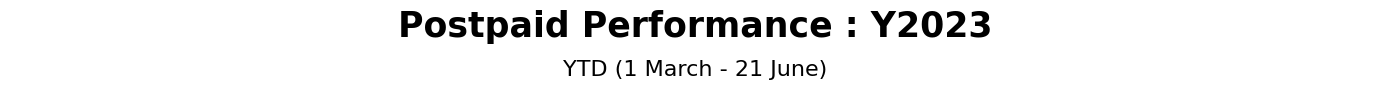

In [120]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Postpaid Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

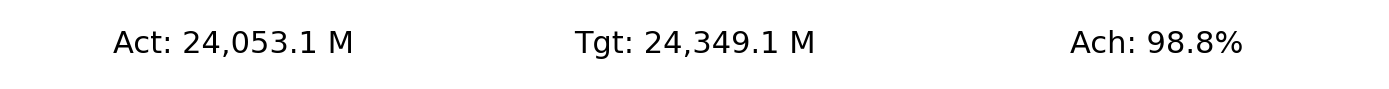

In [121]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

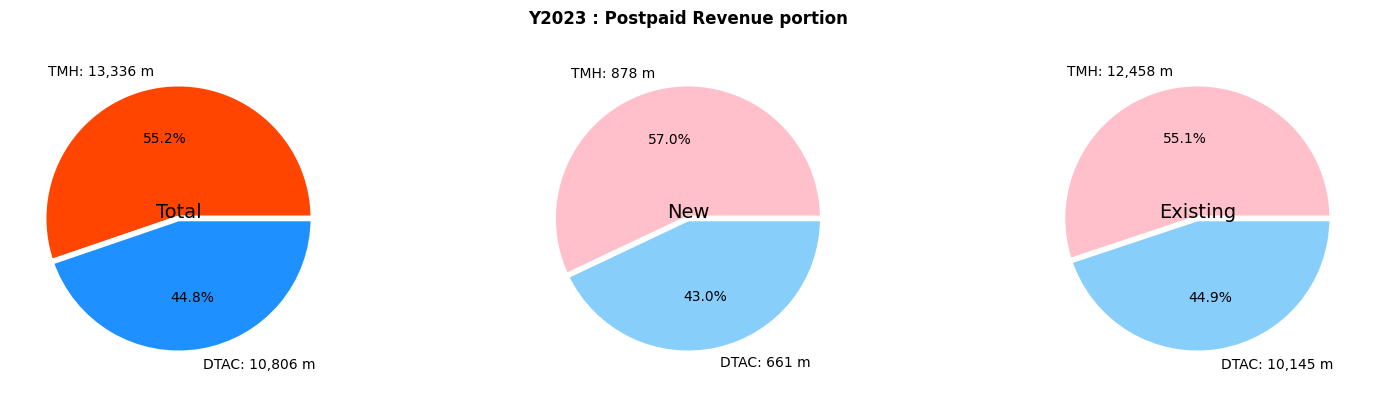

In [122]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} : Postpaid Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_tmh.sum(), y_yr_act_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'Total', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_new_tmh.sum(), y_yr_act_new_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["pink", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'New', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_exist_tmh.sum(), y_yr_act_exist_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["pink", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Existing', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [123]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

# df_rev_mth.to_excel('df_rev_mth.xlsx')
df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
31,TB2R000101,Postpaid New Revenue : TMH,202306,June,S,221.755552,294.467946,0.753072,-72.712395,282.175618,-60.420066,-0.214122
32,TB2R000102,Postpaid Existing Revenue : TMH,202303,March,S,3465.200316,3420.814115,1.012975,44.386201,NaN,NaN,NaN
33,TB2R000102,Postpaid Existing Revenue : TMH,202304,April,S,3473.884688,3338.722898,1.040483,135.161790,3465.200316,8.684372,0.002506
34,TB2R000102,Postpaid Existing Revenue : TMH,202305,May,S,3347.425275,3265.291120,1.025154,82.134155,3473.884688,-126.459413,-0.036403
35,TB2R000102,Postpaid Existing Revenue : TMH,202306,June,S,2171.624763,2197.540532,0.988207,-25.915769,3347.425275,-1175.800512,-0.351255


In [124]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC     ACT_SNAP                             
METRIC_NAME                            EXIST   EXIST_DTAC    EXIST_TMH   
1               202304    April  6270.848061  2796.963373  3473.884688  \
2               202305      May  6102.670212  2755.244936  3347.425275   
3               202306     June  3850.504405  1760.672367  2171.624763   

                                                                            
METRIC_NAME         NEW    NEW_DTAC     NEW_TMH        TOTAL   TOTAL_DTAC   
1            383.266426  163.591058  219.675367  6654.114487  2960.554432  \
2            479.999911  197.824293  282.175618  6582.670122  2953.069229   
3            362.649030  147.717634  221.755552  4213.153434  1908.390001   

             ...         DIFF      %MOM                                  
METRIC_NAME  ...    TOTAL_TMH     EXIST EXIST_DTAC EXIST_TMH       NEW   
1            ...    74.307727 -0.004140  -0.012274  0.002506  0.251598  \
2            ...   -63.959162 -0.026819  -0.014916 -0.036403  0.252392   
3            ... -1236.220578 -0.369046  -0.360974 -0.351255 -0.244481   

                                                                
METRIC_NAME  NEW_DTAC   NEW_TMH     TOTAL TOTAL_DTAC TOTAL_TMH  
1            0.075056  0.425982  0.007720  -0.007820  0.020531  
2            0.209261  0.284512 -0.010737  -0.002528 -0.017316  
3           -0.253289 -0.214122 -0.359963  -0.353760 -0.340594  

[3 rows x 65 columns]

In [125]:
''' Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
mtd_last_act = (df_last_mth['ACT_SNAP']['TOTAL'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_SNAP']['TOTAL'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_SNAP']['TOTAL'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [126]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Values '''
y_mth_act = df_rev_mth_agg['ACT_SNAP']['TOTAL']
y_mth_act_dtac = df_rev_mth_agg['ACT_SNAP']['TOTAL_DTAC']
y_mth_act_tmh = df_rev_mth_agg['ACT_SNAP']['TOTAL_TMH']
y_mth_tgt = df_rev_mth_agg['TGT_SNAP']['TOTAL']
y_mth_tgt_dtac = df_rev_mth_agg['TGT_SNAP']['TOTAL_DTAC']
y_mth_tgt_tmh = df_rev_mth_agg['TGT_SNAP']['TOTAL_TMH']
y_mth_achv = df_rev_mth_agg['%ACHV']['TOTAL']
y_mth_achv_dtac = df_rev_mth_agg['%ACHV']['TOTAL_DTAC']
y_mth_achv_tmh = df_rev_mth_agg['%ACHV']['TOTAL_TMH']
y_mth_gap = df_rev_mth_agg['GAP']['TOTAL']
y_mth_gap_dtac = df_rev_mth_agg['GAP']['TOTAL_DTAC']
y_mth_gap_tmh = df_rev_mth_agg['GAP']['TOTAL_TMH']
y_mth_diff = df_rev_mth_agg['DIFF']['TOTAL']
y_mth_diff_dtac = df_rev_mth_agg['DIFF']['TOTAL_DTAC']
y_mth_diff_tmh = df_rev_mth_agg['DIFF']['TOTAL_TMH']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']['TOTAL']
y_mth_last_act_dtac = df_rev_mth_agg['LAST_ACT']['TOTAL_DTAC']
y_mth_last_act_tmh = df_rev_mth_agg['LAST_ACT']['TOTAL_TMH']
y_mth_mom = df_rev_mth_agg['%MOM']['TOTAL']
y_mth_mom_dtac = df_rev_mth_agg['%MOM']['TOTAL_DTAC']
y_mth_mom_tmh = df_rev_mth_agg['%MOM']['TOTAL_TMH']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT_SNAP']['NEW']
y_mth_act_new_dtac = df_rev_mth_agg['ACT_SNAP']['NEW_DTAC']
y_mth_act_new_tmh = df_rev_mth_agg['ACT_SNAP']['NEW_TMH']
y_mth_tgt_new = df_rev_mth_agg['TGT_SNAP']['NEW']
y_mth_tgt_new_dtac = df_rev_mth_agg['TGT_SNAP']['NEW_DTAC']
y_mth_tgt_new_tmh = df_rev_mth_agg['TGT_SNAP']['NEW_TMH']
y_mth_achv_new = df_rev_mth_agg['%ACHV']['NEW']
y_mth_achv_new_dtac = df_rev_mth_agg['%ACHV']['NEW_DTAC']
y_mth_achv_new_tmh = df_rev_mth_agg['%ACHV']['NEW_TMH']
y_mth_gap_new = df_rev_mth_agg['GAP']['NEW']
y_mth_gap_new_dtac = df_rev_mth_agg['GAP']['NEW_DTAC']
y_mth_gap_new_tmh = df_rev_mth_agg['GAP']['NEW_TMH']
y_mth_diff_new = df_rev_mth_agg['DIFF']['NEW']
y_mth_diff_new_dtac = df_rev_mth_agg['DIFF']['NEW_DTAC']
y_mth_diff_new_tmh = df_rev_mth_agg['DIFF']['NEW_TMH']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT']['NEW']
y_mth_last_act_new_dtac = df_rev_mth_agg['LAST_ACT']['NEW_DTAC']
y_mth_last_act_new_tmh = df_rev_mth_agg['LAST_ACT']['NEW_TMH']
y_mth_mom_new = df_rev_mth_agg['%MOM']['NEW']
y_mth_mom_new_dtac = df_rev_mth_agg['%MOM']['NEW_DTAC']
y_mth_mom_new_tmh = df_rev_mth_agg['%MOM']['NEW_TMH']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT_SNAP']['EXIST']
y_mth_act_exist_dtac = df_rev_mth_agg['ACT_SNAP']['EXIST_DTAC']
y_mth_act_exist_tmh = df_rev_mth_agg['ACT_SNAP']['EXIST_TMH']
y_mth_tgt_exist = df_rev_mth_agg['TGT_SNAP']['EXIST']
y_mth_tgt_exist_dtac = df_rev_mth_agg['TGT_SNAP']['EXIST_DTAC']
y_mth_tgt_exist_tmh = df_rev_mth_agg['TGT_SNAP']['EXIST_TMH']
y_mth_achv_exist = df_rev_mth_agg['%ACHV']['EXIST']
y_mth_achv_exist_dtac = df_rev_mth_agg['%ACHV']['EXIST_DTAC']
y_mth_achv_exist_tmh = df_rev_mth_agg['%ACHV']['EXIST_TMH']
y_mth_gap_exist = df_rev_mth_agg['GAP']['EXIST']
y_mth_gap_exist_dtac = df_rev_mth_agg['GAP']['EXIST_DTAC']
y_mth_gap_exist_tmh = df_rev_mth_agg['GAP']['EXIST_TMH']
y_mth_diff_exist = df_rev_mth_agg['DIFF']['EXIST']
y_mth_diff_exist_dtac = df_rev_mth_agg['DIFF']['EXIST_DTAC']
y_mth_diff_exist_tmh = df_rev_mth_agg['DIFF']['EXIST_TMH']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT']['EXIST']
y_mth_last_act_exist_dtac = df_rev_mth_agg['LAST_ACT']['EXIST_DTAC']
y_mth_last_act_exist_tmh = df_rev_mth_agg['LAST_ACT']['EXIST_TMH']
y_mth_mom_exist = df_rev_mth_agg['%MOM']['EXIST']
y_mth_mom_exist_dtac = df_rev_mth_agg['%MOM']['EXIST_DTAC']
y_mth_mom_exist_tmh = df_rev_mth_agg['%MOM']['EXIST_TMH']

### MTH : Postpaid Revenue Summary

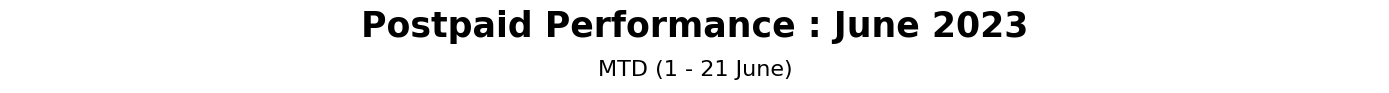

In [127]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Postpaid Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

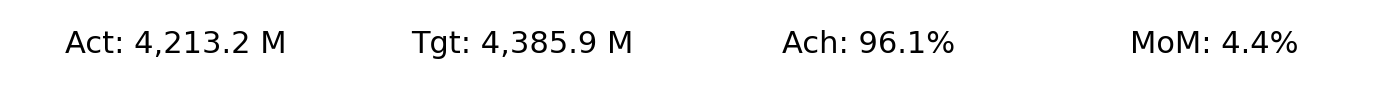

In [128]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

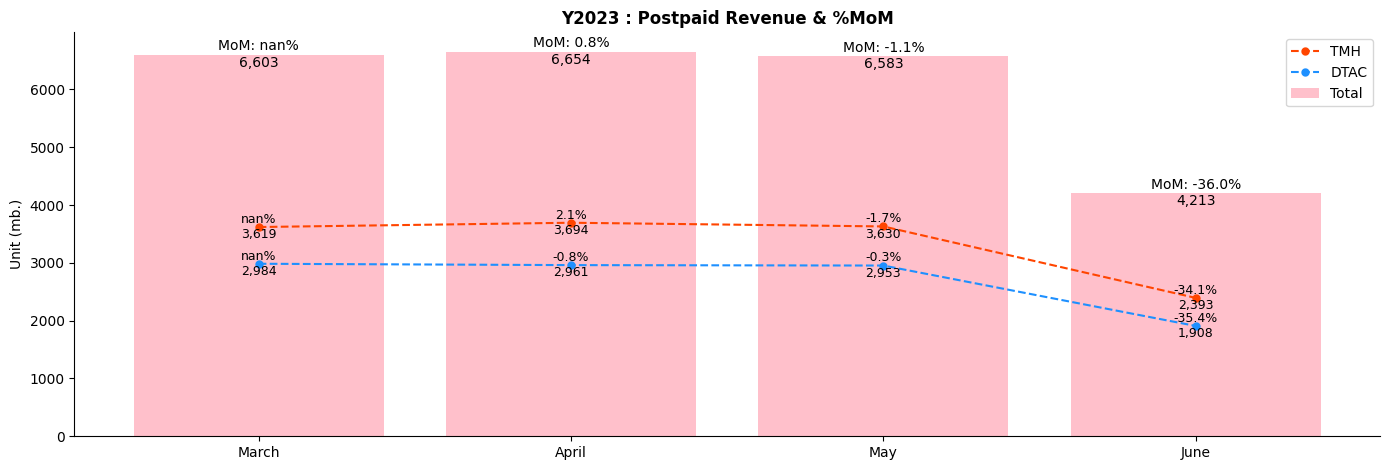

In [129]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Postpaid Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='pink')
plt.plot(x_mth_axis, y_mth_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, y_mth_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_tmh[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-20), ha='center', va='top', fontsize=9)
    plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_dtac[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-20), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

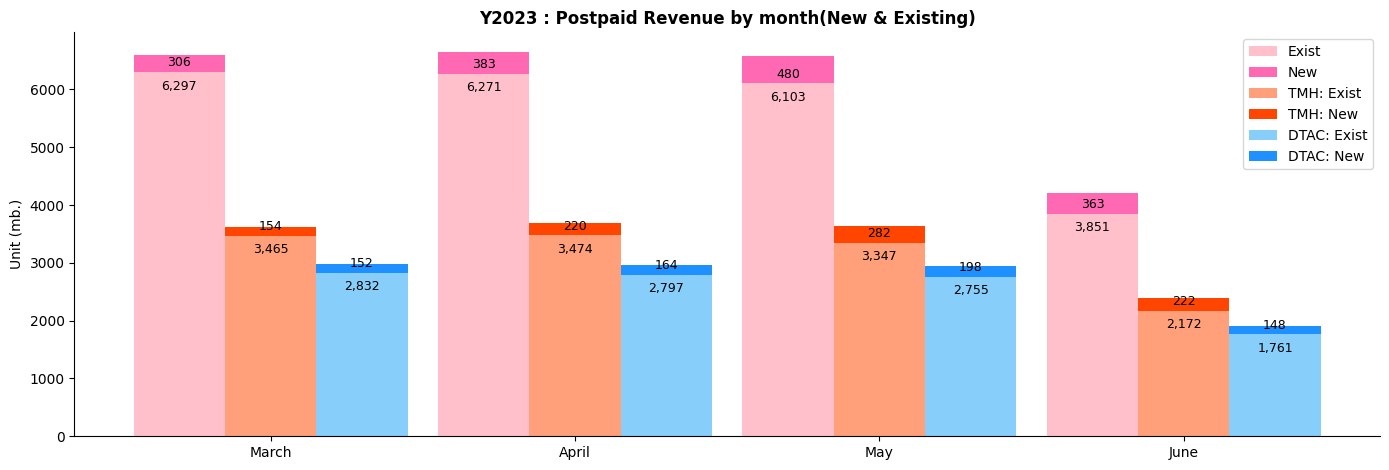

In [130]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3

plt.title(f'Y{curr_yr} : Postpaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_mth_axis-diff_loc, y_mth_act_exist, width, label='Exist', color='pink')
plt.bar(x_mth_axis-diff_loc, y_mth_act_new, width, label='New', color='hotpink', bottom=y_mth_act_exist)
plt.bar(x_mth_axis, y_mth_act_exist_tmh, width, label='TMH: Exist', color='lightsalmon')
plt.bar(x_mth_axis, y_mth_act_new_tmh, width, label='TMH: New', color='orangered', bottom=y_mth_act_exist_tmh)
plt.bar(x_mth_axis+diff_loc, y_mth_act_exist_dtac, width, label='DTAC: Exist', color='lightskyblue')
plt.bar(x_mth_axis+diff_loc, y_mth_act_new_dtac, width, label='DTAC: New', color='dodgerblue', bottom=y_mth_act_exist_dtac)
for i in x_mth_axis:    
    plt.annotate(format(y_mth_act_exist[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]+100), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

### MTH : Postpaid Revenue : TMH vs DTAC

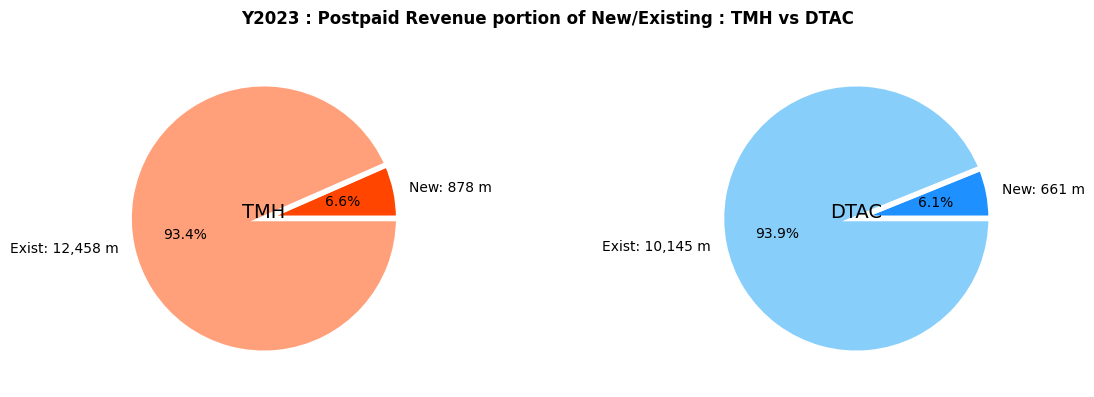

In [131]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} : Postpaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_exist_tmh)])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'TMH', ha='center', fontsize=14)

''' ax2 '''
y = np.array([sum(y_mth_act_new_dtac), sum(y_mth_act_exist_dtac)])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'DTAC', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

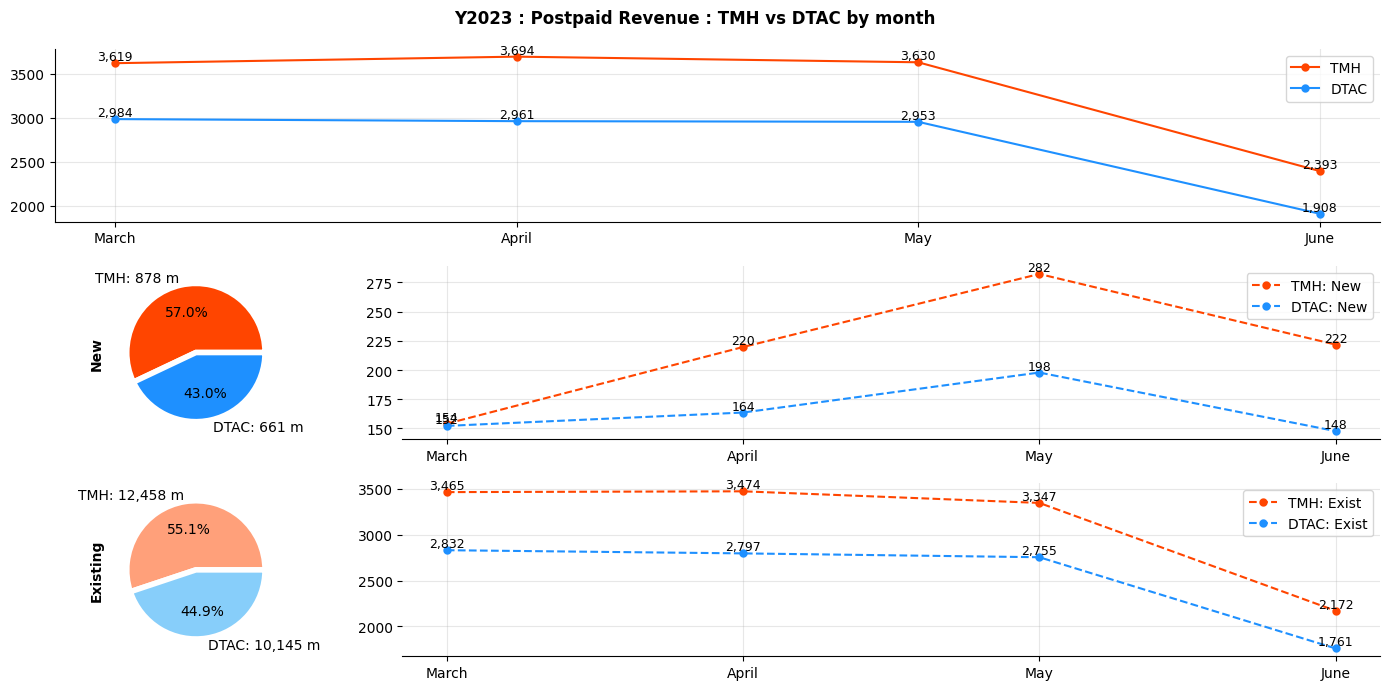

In [132]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} : Postpaid Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_new_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_mth_act_exist_tmh), sum(y_mth_act_exist_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_mth_axis, x_mth)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax4 '''
ax4.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: New', color='orangered')
ax4.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_mth_axis, x_mth)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax4.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax4.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax5 '''
ax5.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: Exist', color='orangered')
ax5.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_mth_axis, x_mth)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax5.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax5.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

### MTH : Postpaid Performance : %Achievement & Gap

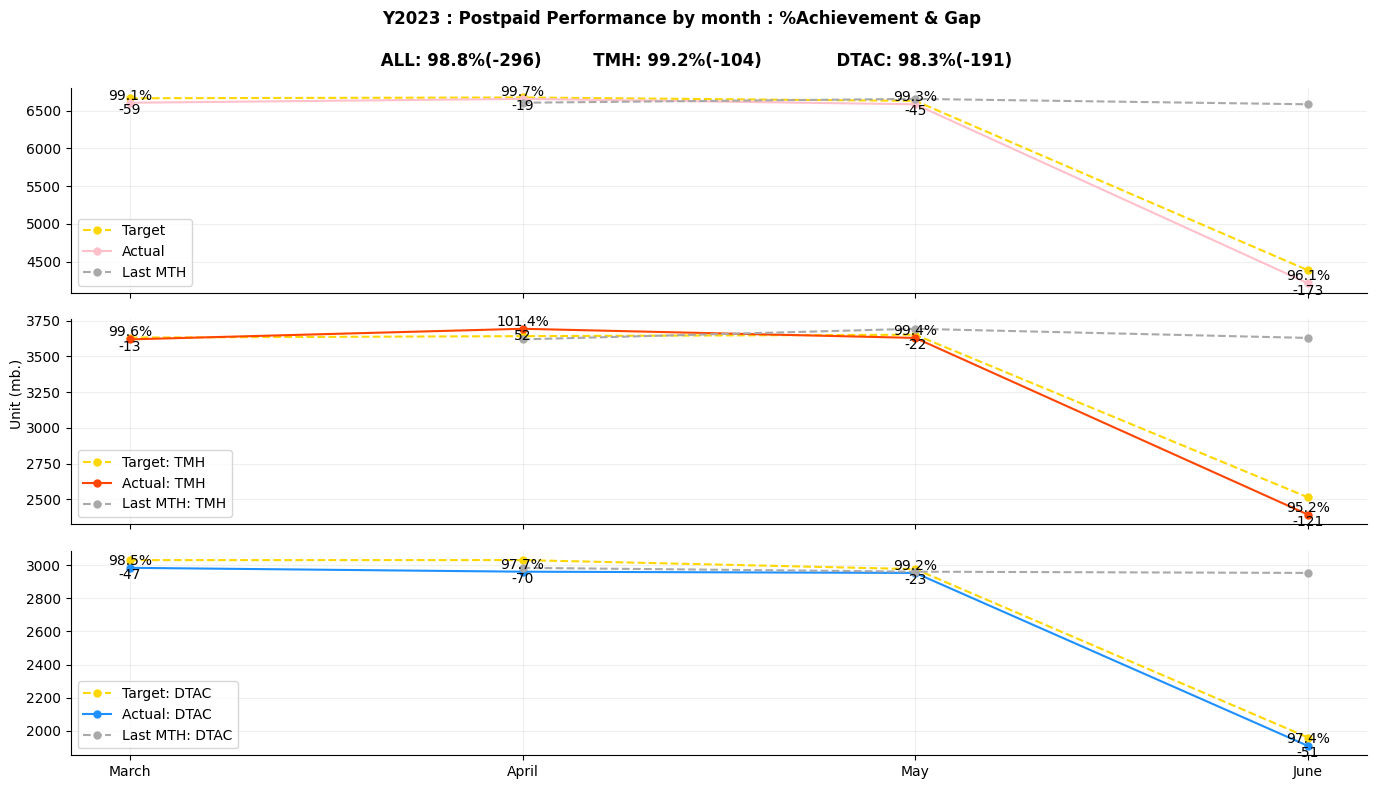

In [133]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} : Postpaid Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(sum(y_mth_gap),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(sum(y_mth_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(sum(y_mth_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], y_mth_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

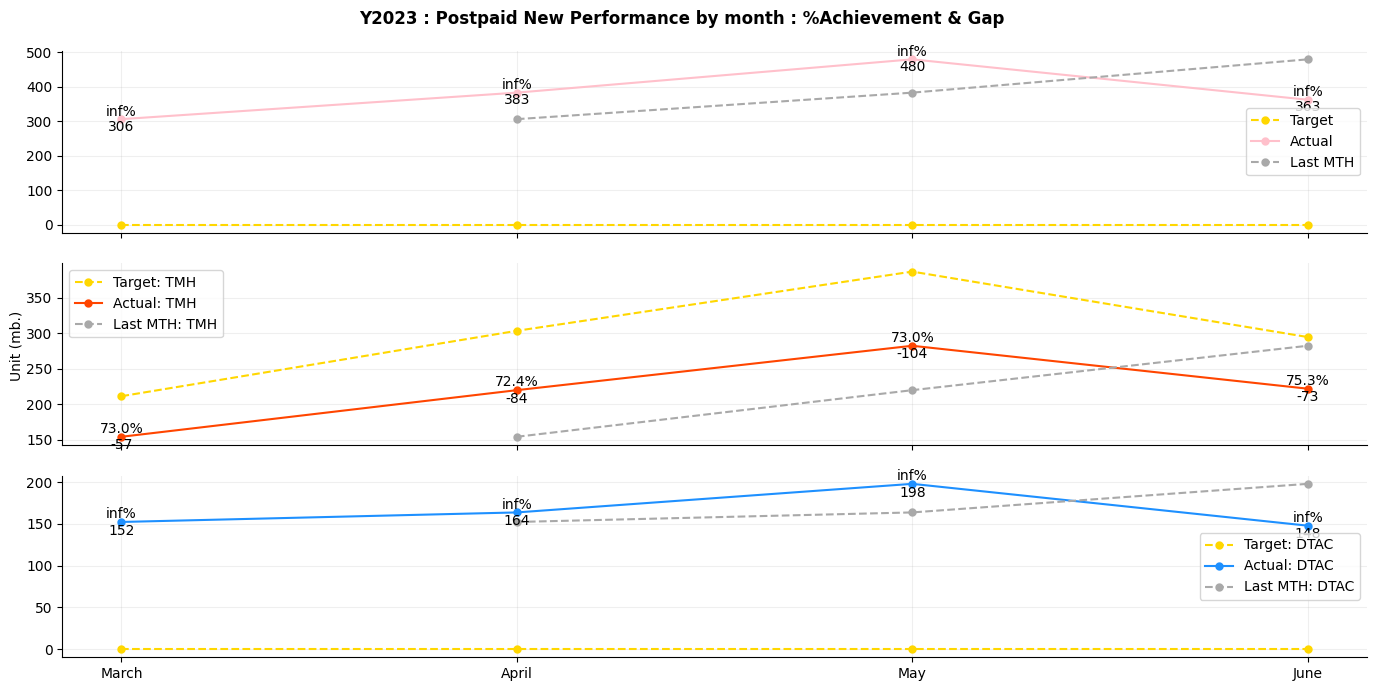

In [134]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} : Postpaid New Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_new, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_new[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_new[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_new_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_new_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

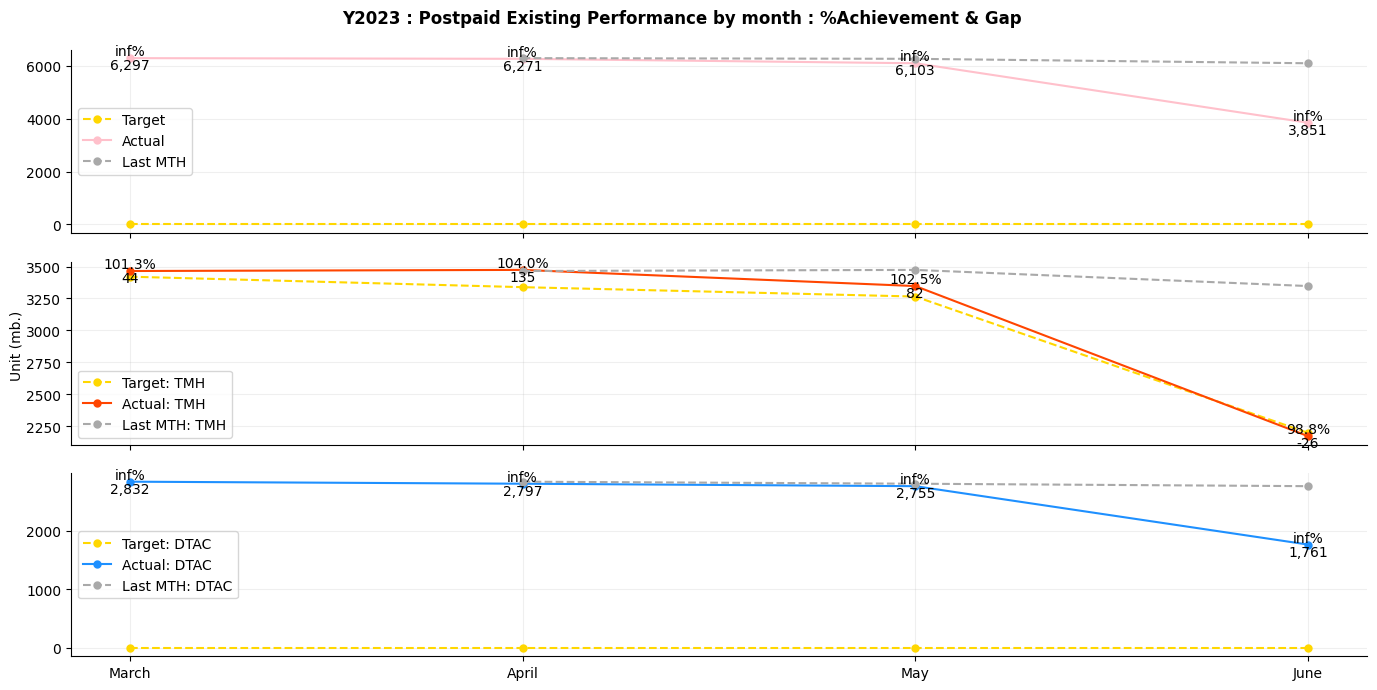

In [135]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} : Postpaid Existing Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_exist, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_exist[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_exist[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_exist_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_exist_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly **

### WK : Aggregation

In [136]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

# df_rev_wk.to_excel('df_rev_wk.xlsx')
df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
150,TB2R000102,Postpaid Existing Revenue : TMH,2023023,23,S,631.177841,642.198140,0.982840,-11.020299,549.954112,81.223729,0.147692
151,TB2R000102,Postpaid Existing Revenue : TMH,2023024,24,S,686.985825,688.838572,0.997310,-1.852747,631.177841,55.807984,0.088419
152,TB2R000102,Postpaid Existing Revenue : TMH,2023025,25,S,310.547526,322.961375,0.961562,-12.413849,686.985825,-376.438299,-0.547956


In [137]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                           
METRIC_NAME                           EXIST  EXIST_DTAC   EXIST_TMH   
14            2023023       23  1243.731563  612.553722  631.177841  \
15            2023024       24  1252.103939  565.118114  686.985825   
16            2023025       25   392.889777  164.134977  310.547526   

                                                                        ...   
METRIC_NAME         NEW   NEW_DTAC    NEW_TMH        TOTAL  TOTAL_DTAC  ...   
14           119.449660  52.071698  67.377962  1363.181222  664.625420  ...  \
15           116.373306  47.757685  68.615621  1368.477245  612.875799  ...   
16            43.577608  13.316630  37.085134   436.467385  177.451607  ...   

                   DIFF      %WOW                                            
METRIC_NAME   TOTAL_TMH     EXIST EXIST_DTAC EXIST_TMH       NEW  NEW_DTAC   
14            99.601719 -0.011245  -0.134716  0.147692  0.126399 -0.087192  \
15            57.045643  0.006732  -0.077439  0.088419 -0.025754 -0.082848   
16          -407.968786 -0.686216  -0.709556 -0.547956 -0.625536 -0.721163   

                                                      
METRIC_NAME   NEW_TMH     TOTAL TOTAL_DTAC TOTAL_TMH  
14           0.375061 -0.000543  -0.131172  0.166293  
15           0.018369  0.003885  -0.077863  0.081662  
16          -0.459523 -0.681056  -0.710461 -0.539926  

[3 rows x 65 columns]

In [138]:
''' Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())

wtd_last_act = (df_last_wk['ACT_SNAP']['TOTAL'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_SNAP']['TOTAL'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_SNAP']['TOTAL'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [139]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_rev_wk_agg['ACT_SNAP']['TOTAL']
y_wk_act_dtac = df_rev_wk_agg['ACT_SNAP']['TOTAL_DTAC']
y_wk_act_tmh = df_rev_wk_agg['ACT_SNAP']['TOTAL_TMH']
y_wk_tgt = df_rev_wk_agg['TGT_SNAP']['TOTAL']
y_wk_tgt_dtac = df_rev_wk_agg['TGT_SNAP']['TOTAL_DTAC']
y_wk_tgt_tmh = df_rev_wk_agg['TGT_SNAP']['TOTAL_TMH']
y_wk_achv = df_rev_wk_agg['%ACHV']['TOTAL']
y_wk_achv_dtac = df_rev_wk_agg['%ACHV']['TOTAL_DTAC']
y_wk_achv_tmh = df_rev_wk_agg['%ACHV']['TOTAL_TMH']
y_wk_gap = df_rev_wk_agg['GAP']['TOTAL']
y_wk_gap_dtac = df_rev_wk_agg['GAP']['TOTAL_DTAC']
y_wk_gap_tmh = df_rev_wk_agg['GAP']['TOTAL_TMH']
y_wk_diff = df_rev_wk_agg['DIFF']['TOTAL']
y_wk_diff_dtac = df_rev_wk_agg['DIFF']['TOTAL_DTAC']
y_wk_diff_tmh = df_rev_wk_agg['DIFF']['TOTAL_TMH']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']['TOTAL']
y_wk_last_act_dtac = df_rev_wk_agg['LAST_ACT']['TOTAL_DTAC']
y_wk_last_act_tmh = df_rev_wk_agg['LAST_ACT']['TOTAL_TMH']
y_wk_wow = df_rev_wk_agg['%WOW']['TOTAL']
y_wk_wow_dtac = df_rev_wk_agg['%WOW']['TOTAL_DTAC']
y_wk_wow_tmh = df_rev_wk_agg['%WOW']['TOTAL_TMH']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT_SNAP']['NEW']
y_wk_act_new_dtac = df_rev_wk_agg['ACT_SNAP']['NEW_DTAC']
y_wk_act_new_tmh = df_rev_wk_agg['ACT_SNAP']['NEW_TMH']
y_wk_tgt_new = df_rev_wk_agg['TGT_SNAP']['NEW']
y_wk_tgt_new_dtac = df_rev_wk_agg['TGT_SNAP']['NEW_DTAC']
y_wk_tgt_new_tmh = df_rev_wk_agg['TGT_SNAP']['NEW_TMH']
y_wk_achv_new = df_rev_wk_agg['%ACHV']['NEW']
y_wk_achv_new_dtac = df_rev_wk_agg['%ACHV']['NEW_DTAC']
y_wk_achv_new_tmh = df_rev_wk_agg['%ACHV']['NEW_TMH']
y_wk_gap_new = df_rev_wk_agg['GAP']['NEW']
y_wk_gap_new_dtac = df_rev_wk_agg['GAP']['NEW_DTAC']
y_wk_gap_new_tmh = df_rev_wk_agg['GAP']['NEW_TMH']
y_wk_diff_new = df_rev_wk_agg['DIFF']['NEW']
y_wk_diff_new_dtac = df_rev_wk_agg['DIFF']['NEW_DTAC']
y_wk_diff_new_tmh = df_rev_wk_agg['DIFF']['NEW_TMH']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT']['NEW']
y_wk_last_act_new_dtac = df_rev_wk_agg['LAST_ACT']['NEW_DTAC']
y_wk_last_act_new_tmh = df_rev_wk_agg['LAST_ACT']['NEW_TMH']
y_wk_wow_new = df_rev_wk_agg['%WOW']['NEW']
y_wk_wow_new_dtac = df_rev_wk_agg['%WOW']['NEW_DTAC']
y_wk_wow_new_tmh = df_rev_wk_agg['%WOW']['NEW_TMH']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT_SNAP']['EXIST']
y_wk_act_exist_dtac = df_rev_wk_agg['ACT_SNAP']['EXIST_DTAC']
y_wk_act_exist_tmh = df_rev_wk_agg['ACT_SNAP']['EXIST_TMH']
y_wk_tgt_exist = df_rev_wk_agg['TGT_SNAP']['EXIST']
y_wk_tgt_exist_dtac = df_rev_wk_agg['TGT_SNAP']['EXIST_DTAC']
y_wk_tgt_exist_tmh = df_rev_wk_agg['TGT_SNAP']['EXIST_TMH']
y_wk_achv_exist = df_rev_wk_agg['%ACHV']['EXIST']
y_wk_achv_exist_dtac = df_rev_wk_agg['%ACHV']['EXIST_DTAC']
y_wk_achv_exist_tmh = df_rev_wk_agg['%ACHV']['EXIST_TMH']
y_wk_gap_exist = df_rev_wk_agg['GAP']['EXIST']
y_wk_gap_exist_dtac = df_rev_wk_agg['GAP']['EXIST_DTAC']
y_wk_gap_exist_tmh = df_rev_wk_agg['GAP']['EXIST_TMH']
y_wk_diff_exist = df_rev_wk_agg['DIFF']['EXIST']
y_wk_diff_exist_dtac = df_rev_wk_agg['DIFF']['EXIST_DTAC']
y_wk_diff_exist_tmh = df_rev_wk_agg['DIFF']['EXIST_TMH']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT']['EXIST']
y_wk_last_act_exist_dtac = df_rev_wk_agg['LAST_ACT']['EXIST_DTAC']
y_wk_last_act_exist_tmh = df_rev_wk_agg['LAST_ACT']['EXIST_TMH']
y_wk_wow_exist = df_rev_wk_agg['%WOW']['EXIST']
y_wk_wow_exist_dtac = df_rev_wk_agg['%WOW']['EXIST_DTAC']
y_wk_wow_exist_tmh = df_rev_wk_agg['%WOW']['EXIST_TMH']

### WK : Postpaid Revenue Summary

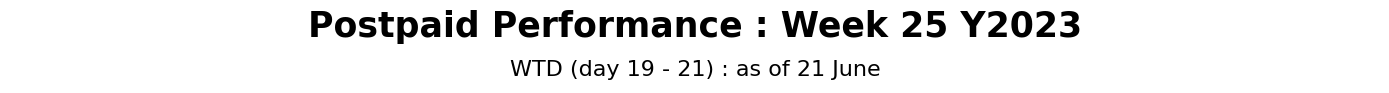

In [140]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Postpaid Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

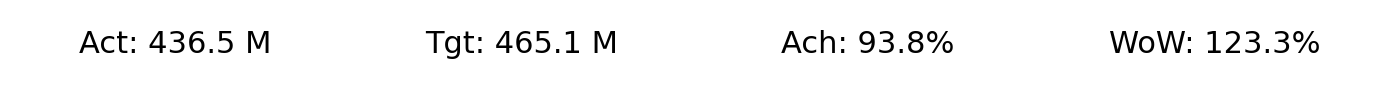

In [141]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

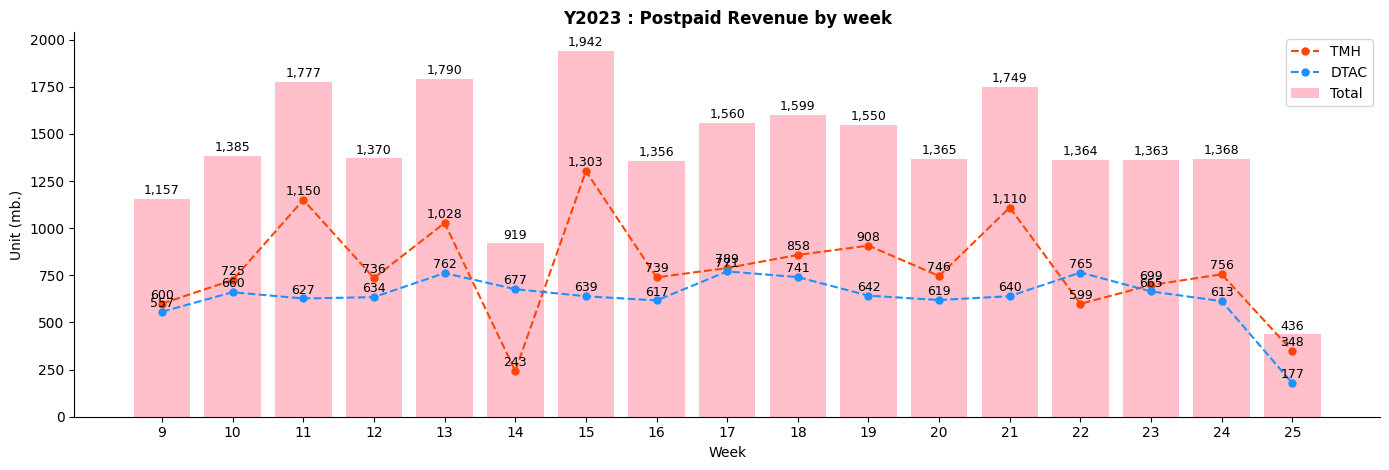

In [142]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : Postpaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, y_wk_act, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

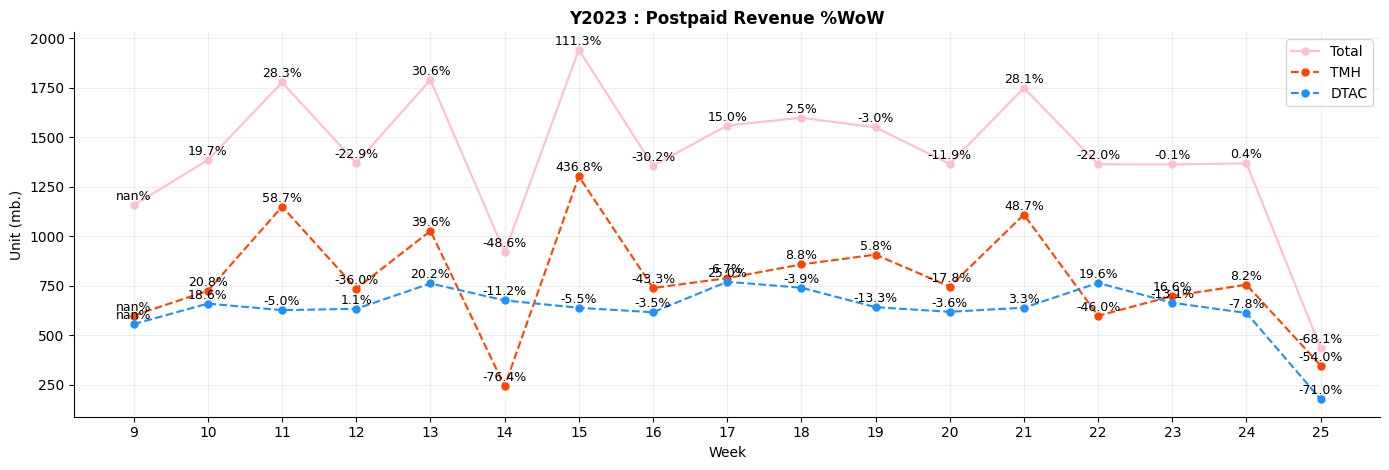

In [143]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : Postpaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### WK : Postpaid Performance : %Achievement & Gap

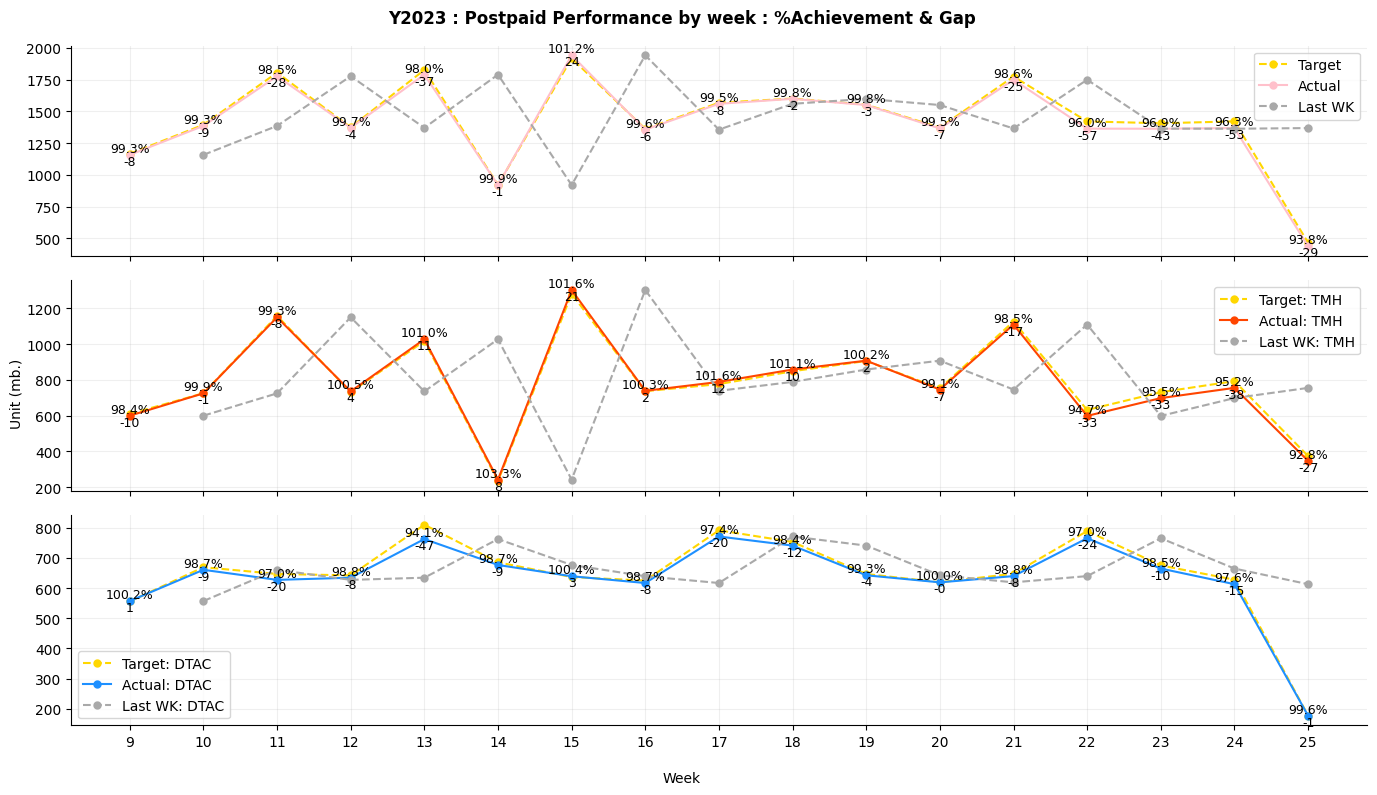

In [144]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} : Postpaid Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, y_wk_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_wk_axis, y_wk_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_wk_gap[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, y_wk_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, y_wk_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_wk_axis, y_wk_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_wk_gap_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, y_wk_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, y_wk_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_wk_axis, y_wk_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_wk_gap_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [145]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT_SNAP']['TOTAL'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [146]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT_SNAP']['TOTAL'].sum()
last_day_rev_new = df_rev_day_last_day['ACT_SNAP']['NEW'].sum()
last_day_rev_exist = df_rev_day_last_day['ACT_SNAP']['EXIST'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT_SNAP']['TOTAL'].sum()
dtd_tgt = df_rev_day_curr_day['TGT_SNAP']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT_SNAP']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_rev_day_curr_day['ACT_SNAP']['NEW'].sum()
dtd_tgt_new = df_rev_day_curr_day['TGT_SNAP']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_rev_day_last_day['ACT_SNAP']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_rev_day_curr_day['ACT_SNAP']['EXIST'].sum()
dtd_tgt_exist = df_rev_day_curr_day['TGT_SNAP']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_rev_day_last_day['ACT_SNAP']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_2963/2937623348.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  dtd_achv_new = dtd_rev_new / dtd_tgt_new
/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_2963/2937623348.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist


In [147]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_rev_day_curr_mth['ACT_SNAP']['TOTAL']
y_day_act_dtac = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_DTAC']
y_day_act_tmh = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_TMH']
y_day_tgt = df_rev_day_curr_mth['TGT_SNAP']['TOTAL']
y_day_tgt_dtac = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_DTAC']
y_day_tgt_tmh = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_TMH']
y_day_achv = df_rev_day_curr_mth['%ACHV']['TOTAL']
y_day_achv_dtac = df_rev_day_curr_mth['%ACHV']['TOTAL_DTAC']
y_day_achv_tmh = df_rev_day_curr_mth['%ACHV']['TOTAL_TMH']
y_day_gap = df_rev_day_curr_mth['GAP']['TOTAL']
y_day_gap_dtac = df_rev_day_curr_mth['GAP']['TOTAL_DTAC']
y_day_gap_tmh = df_rev_day_curr_mth['GAP']['TOTAL_TMH']
y_day_diff = df_rev_day_curr_mth['DIFF']['TOTAL']
y_day_diff_dtac = df_rev_day_curr_mth['DIFF']['TOTAL_DTAC']
y_day_diff_tmh = df_rev_day_curr_mth['DIFF']['TOTAL_TMH']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']['TOTAL']
y_day_last_act_dtac = df_rev_day_curr_mth['LAST_ACT']['TOTAL_DTAC']
y_day_last_act_tmh = df_rev_day_curr_mth['LAST_ACT']['TOTAL_TMH']
y_day_dod = df_rev_day_curr_mth['%DOD']['TOTAL']
y_day_dod_dtac = df_rev_day_curr_mth['%DOD']['TOTAL_DTAC']
y_day_dod_tmh = df_rev_day_curr_mth['%DOD']['TOTAL_TMH']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT_SNAP']['NEW']
y_day_act_new_dtac = df_rev_day_curr_mth['ACT_SNAP']['NEW_DTAC']
y_day_act_new_tmh = df_rev_day_curr_mth['ACT_SNAP']['NEW_TMH']
y_day_tgt_new = df_rev_day_curr_mth['TGT_SNAP']['NEW']
y_day_tgt_new_dtac = df_rev_day_curr_mth['TGT_SNAP']['NEW_DTAC']
y_day_tgt_new_tmh = df_rev_day_curr_mth['TGT_SNAP']['NEW_TMH']
y_day_achv_new = df_rev_day_curr_mth['%ACHV']['NEW']
y_day_achv_new_dtac = df_rev_day_curr_mth['%ACHV']['NEW_DTAC']
y_day_achv_new_tmh = df_rev_day_curr_mth['%ACHV']['NEW_TMH']
y_day_gap_new = df_rev_day_curr_mth['GAP']['NEW']
y_day_gap_new_dtac = df_rev_day_curr_mth['GAP']['NEW_DTAC']
y_day_gap_new_tmh = df_rev_day_curr_mth['GAP']['NEW_TMH']
y_day_diff_new = df_rev_day_curr_mth['DIFF']['NEW']
y_day_diff_new_dtac = df_rev_day_curr_mth['DIFF']['NEW_DTAC']
y_day_diff_new_tmh = df_rev_day_curr_mth['DIFF']['NEW_TMH']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT']['NEW']
y_day_last_act_new_dtac = df_rev_day_curr_mth['LAST_ACT']['NEW_DTAC']
y_day_last_act_new_tmh = df_rev_day_curr_mth['LAST_ACT']['NEW_TMH']
y_day_dod_new = df_rev_day_curr_mth['%DOD']['NEW']
y_day_dod_new_dtac = df_rev_day_curr_mth['%DOD']['NEW_DTAC']
y_day_dod_new_tmh = df_rev_day_curr_mth['%DOD']['NEW_TMH']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT_SNAP']['EXIST']
y_day_act_exist_dtac = df_rev_day_curr_mth['ACT_SNAP']['EXIST_DTAC']
y_day_act_exist_tmh = df_rev_day_curr_mth['ACT_SNAP']['EXIST_TMH']
y_day_tgt_exist = df_rev_day_curr_mth['TGT_SNAP']['EXIST']
y_day_tgt_exist_dtac = df_rev_day_curr_mth['TGT_SNAP']['EXIST_DTAC']
y_day_tgt_exist_tmh = df_rev_day_curr_mth['TGT_SNAP']['EXIST_TMH']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV']['EXIST']
y_day_achv_exist_dtac = df_rev_day_curr_mth['%ACHV']['EXIST_DTAC']
y_day_achv_exist_tmh = df_rev_day_curr_mth['%ACHV']['EXIST_TMH']
y_day_gap_exist = df_rev_day_curr_mth['GAP']['EXIST']
y_day_gap_exist_dtac = df_rev_day_curr_mth['GAP']['EXIST_DTAC']
y_day_gap_exist_tmh = df_rev_day_curr_mth['GAP']['EXIST_TMH']
y_day_diff_exist = df_rev_day_curr_mth['DIFF']['EXIST']
y_day_diff_exist_dtac = df_rev_day_curr_mth['DIFF']['EXIST_DTAC']
y_day_diff_exist_tmh = df_rev_day_curr_mth['DIFF']['EXIST_TMH']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT']['EXIST']
y_day_last_act_exist_dtac = df_rev_day_curr_mth['LAST_ACT']['EXIST_DTAC']
y_day_last_act_exist_tmh = df_rev_day_curr_mth['LAST_ACT']['EXIST_TMH']
y_day_dod_exist = df_rev_day_curr_mth['%DOD']['EXIST']
y_day_dod_exist_dtac = df_rev_day_curr_mth['%DOD']['EXIST_DTAC']
y_day_dod_exist_tmh = df_rev_day_curr_mth['%DOD']['EXIST_TMH']

### DAY : Postpaid Revenue Summary

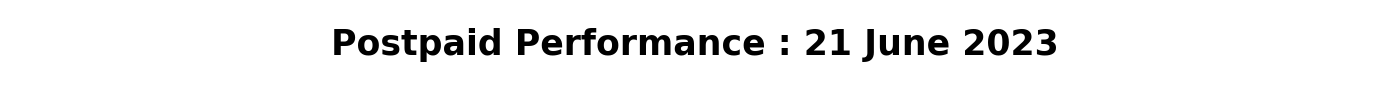

In [148]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"Postpaid Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

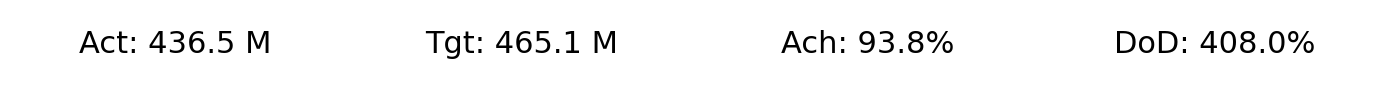

In [149]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(dtd_rev,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(dtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

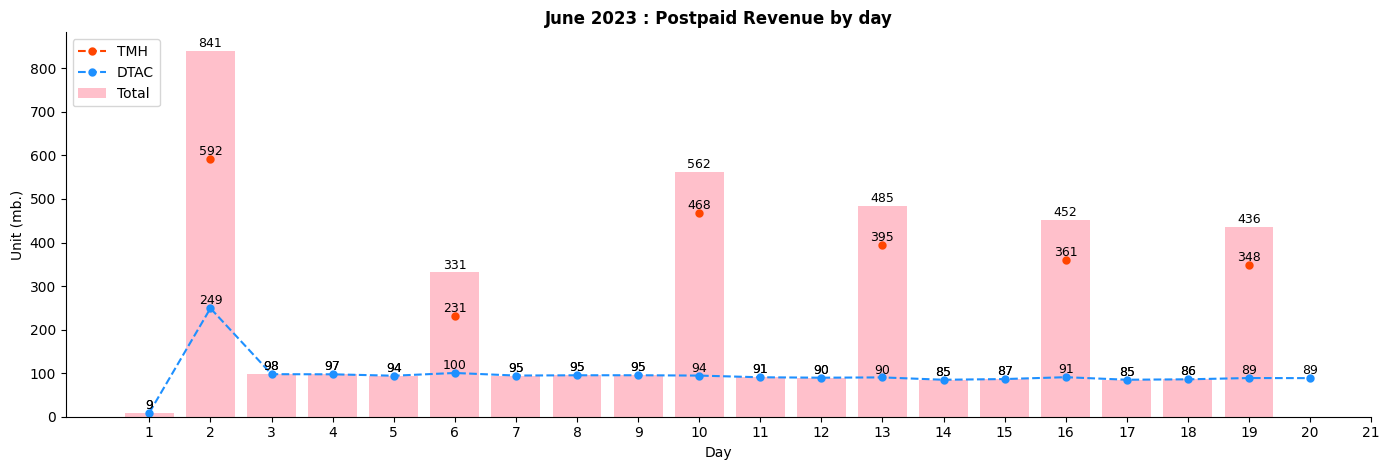

In [150]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel(f'Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

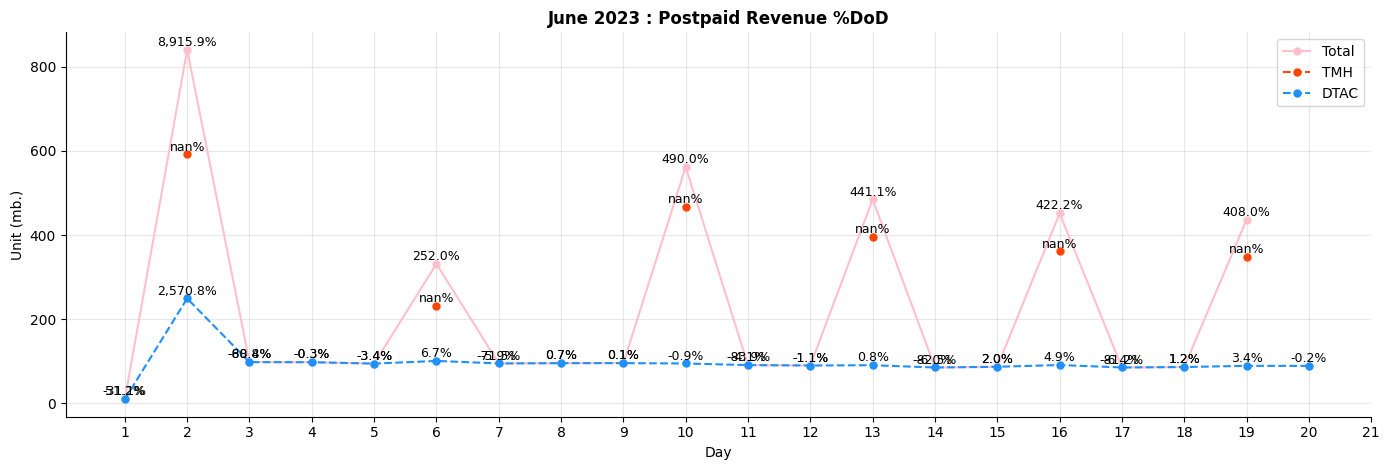

In [151]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)

plt.xlabel(f'Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### DAY : Postpaid Performance : %Achievement & Gap

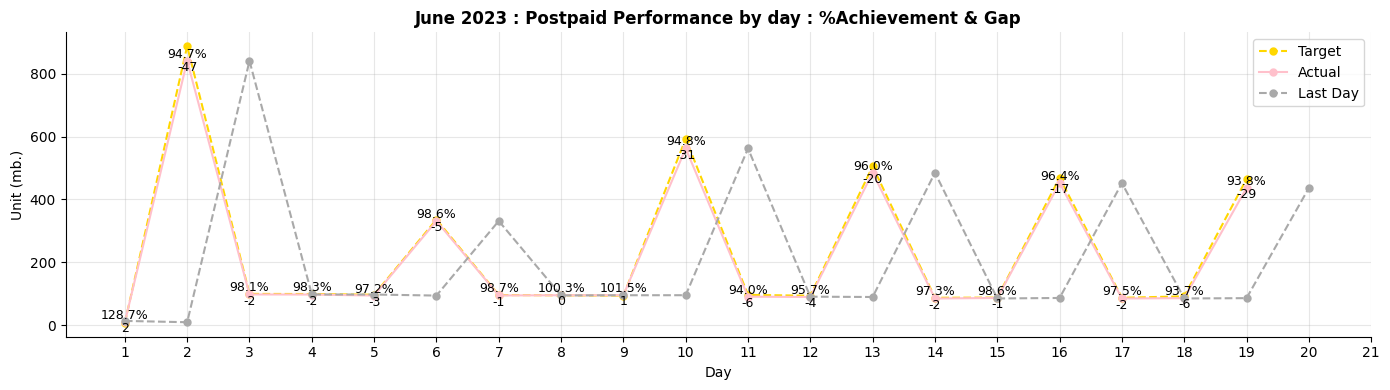

In [152]:
''' Peformance : %Achievement & Gap : Day Chart '''

# plt.figure().set_figwidth(14)
plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : Postpaid Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, y_day_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, y_day_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], y_day_act[i]+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_gap[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-0.2), ha='center', va='top', fontsize=9)

plt.xlabel(f'Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

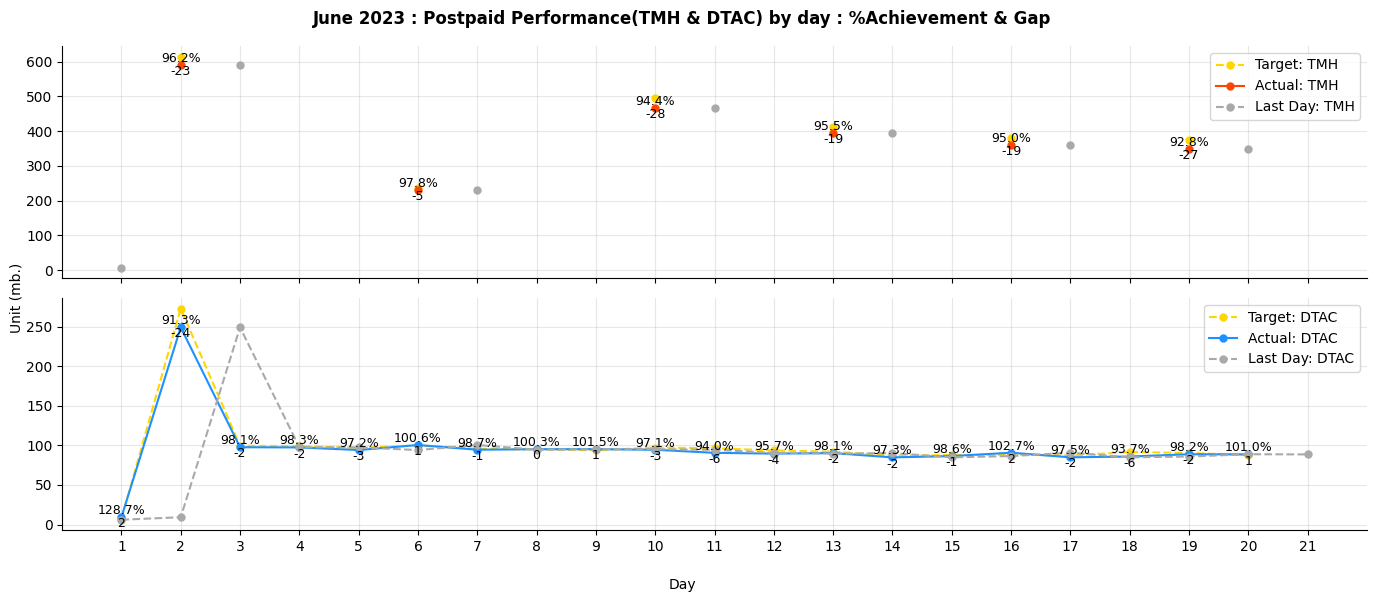

In [153]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Postpaid Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, y_day_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, y_day_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, y_day_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], y_day_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_day_gap_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, y_day_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, y_day_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, y_day_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], y_day_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_day_gap_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel(f'Day', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()